In [1]:
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
# plt.style.use("fivethirtyeight")
plt.rcdefaults()
plt.style.use('default')

%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime, timedelta

## ARIMA/HWES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten
import keras.regularizers
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
days_to_subtract = (end.weekday() - 0) % 7  # 0 represents Monday
nearest_mon = end - timedelta(days=days_to_subtract)
start = datetime(nearest_mon.year - 5, nearest_mon.month, nearest_mon.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
AAPL = AAPL.drop(columns=['company_name'])
exog = AAPL[['Open', 'High', 'Low', 'Volume']]
df = AAPL['Close']
df = pd.DataFrame(df, columns=['Close'])
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

## Exploratory Data Analysis

<AxesSubplot: xlabel='Date'>

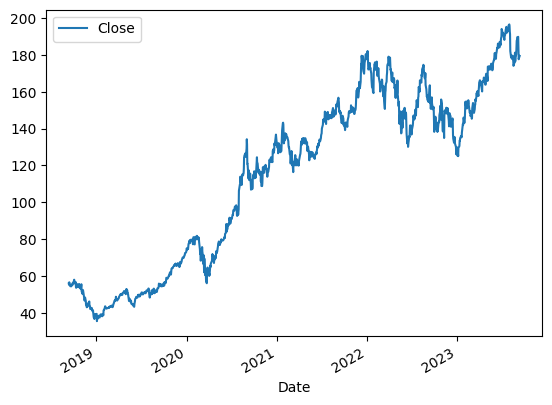

In [4]:
df.plot()

<AxesSubplot: ylabel='Frequency'>

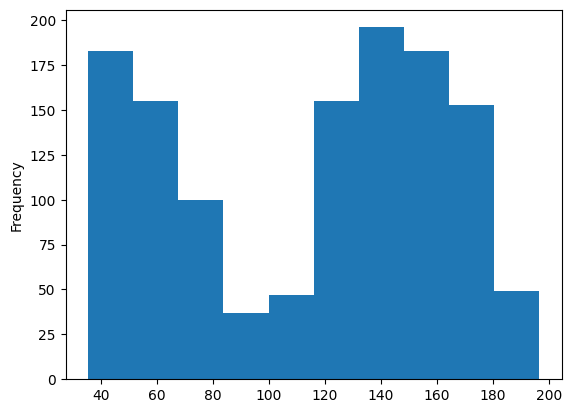

In [5]:
df['Close'].plot(kind='hist')

<AxesSubplot: >

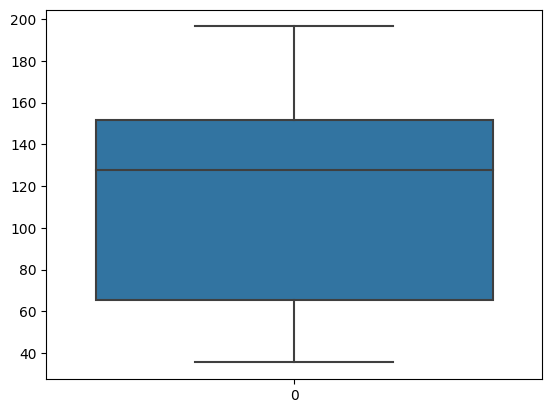

In [6]:
sns.boxplot(df['Close'])

## Decomposition Plot

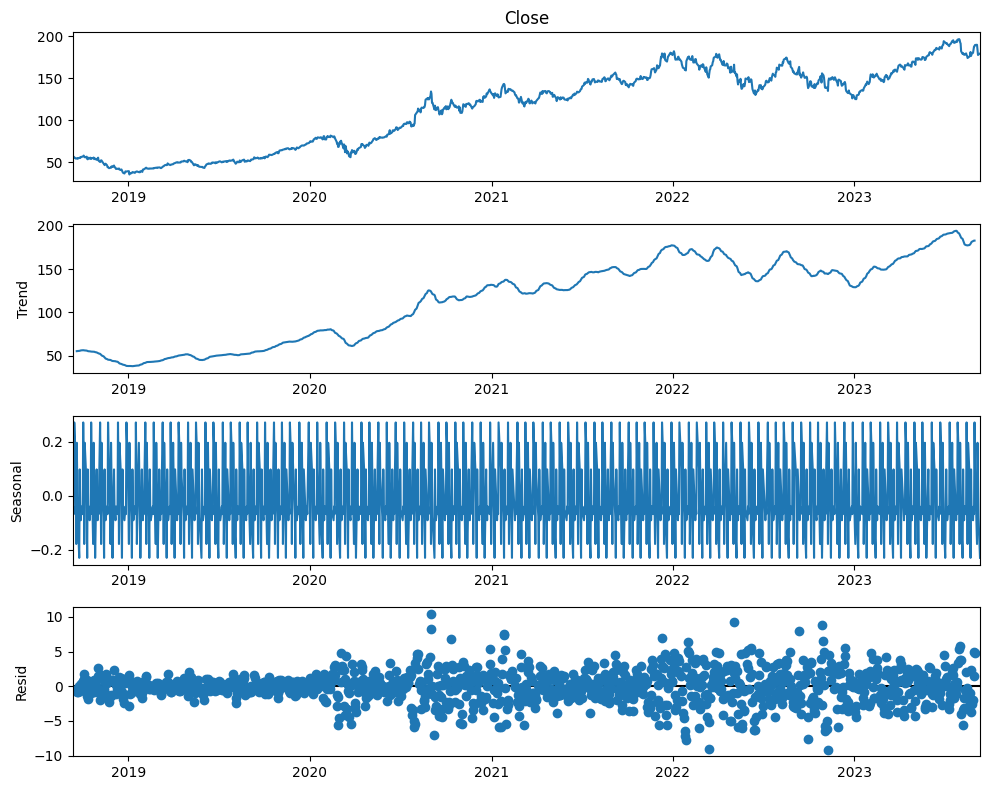

In [7]:
result = seasonal_decompose(df['Close'], model='additive', period=12)
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

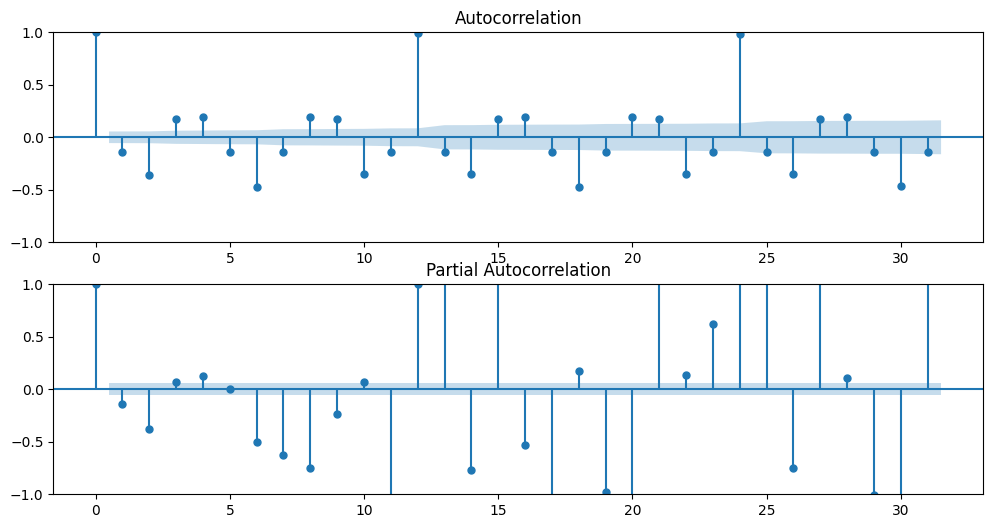

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

## Check For Stationary

In [9]:
## identify min and max index in the dataframe
index = df.index
mindex = index.min()
maxdex = index.max()

print("min index: " + str(mindex))
print("max index: " + str(maxdex))

min index: 2018-09-11 00:00:00
max index: 2023-09-11 00:00:00


In [10]:
## checking for stationarity
test1 = df[df.index<='2021-04']
test2 = df[df.index>'2021-04']
test1Mean = test1['Close'].mean()
test2Mean = test2['Close'].mean()
test1Var = test1['Close'].var()
test2Var = test2['Close'].var()
print(f'Group 1 Mean: {test1Mean} | Group 2 Mean: {test2Mean}')
print(f'Group 1 Var: {test1Var} | Group 2 Var: {test2Var}')

Group 1 Mean: 76.12616448965132 | Group 2 Mean: 155.5408795136194
Group 1 Var: 942.4518051982883 | Group 2 Var: 301.3745323201174


In [11]:
## conduct augmented dicky fuller test
pval = adfuller(df['Close'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.825445


## First-Order Differential

In [12]:
# df = df.diff()
# df = df.dropna()

In [13]:
## conduct augmented dicky fuller test
pval = adfuller(df['Close'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.825445


## ACF & PACF Plots

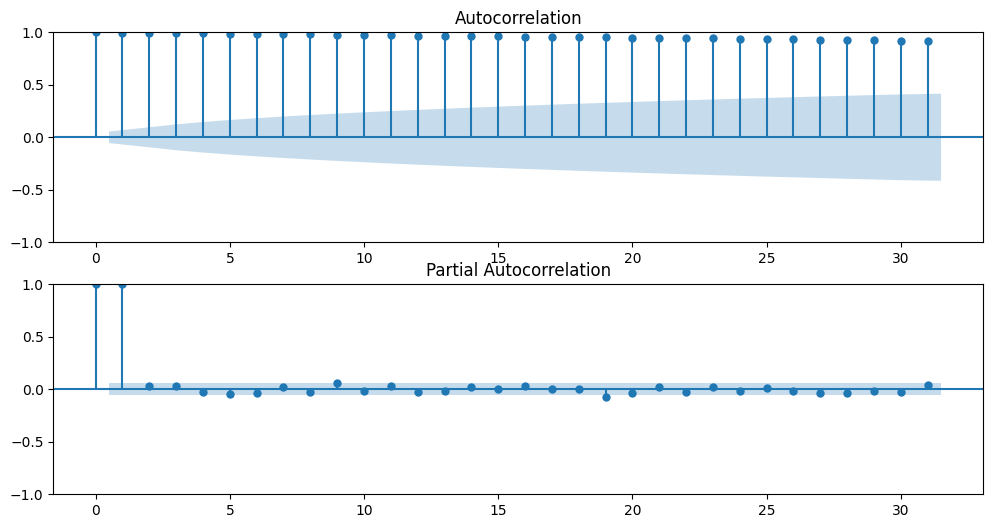

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['Close'], ax=ax[0])
plot_pacf(df['Close'], ax=ax[1])
plt.show()

## Data Preprocessing

In [35]:
train_data = df[:1000]
test_data = df[1000:]

In [36]:
train_start = str(train_data.index[0])[0:10]
train_end = str(train_data.index[-1])[0:10]

test_start = str(test_data.index[0])[0:10]
test_end = str(test_data.index[-1])[0:10]

In [37]:
## MinMax scale data
train_scaler = MinMaxScaler(feature_range=(0, 1))
test_scaler = MinMaxScaler(feature_range=(0, 1))

train_data = train_scaler.fit_transform(train_data)
test_data = test_scaler.fit_transform(test_data)

print('train_data shape: ' + str(train_data.shape))
print('test_data shape: ' + str(test_data.shape))

train_data shape: (1000, 1)
test_data shape: (258, 1)


In [38]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [39]:
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [40]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (996, 3)
Shape of train labels: (996,)
Shape of test input: (254, 3)
Shape of test labels: (254,)


In [41]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (996, 1, 3)
Shape of train labels: (996,)
Shape of test input: (254, 1, 3)
Shape of test labels: (254,)


In [42]:
l2 = keras.regularizers.L2(0.01)

model = Sequential()

model.add(LSTM(32, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256, return_sequences=True))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2))

model.add(Dense(1, activation='relu'))

adam = Adam(learning_rate=0.01)
sgd = SGD()
model.compile(optimizer=adam, loss='mean_squared_error')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 32)             4608      
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             24832     
                                                                 
 lstm_6 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_7 (LSTM)               (None, 1, 256)            394240    
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 128)              

In [44]:
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.05, patience=5, min_lr=0.00001)

history = model.fit(trainX, trainY, epochs=300, batch_size=64, verbose=1, workers=-1, use_multiprocessing=True)

Epoch 1/300
16/16 [==============================] - 4s 9ms/step - loss: 1.6468
Epoch 2/300
16/16 [==============================] - 0s 9ms/step - loss: 0.2562
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0639
Epoch 4/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0249
Epoch 5/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0203
Epoch 6/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0164
Epoch 7/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0148
Epoch 8/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 9/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 10/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0131
Epoch 11/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 12/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 13/300
16/16 [=================

In [45]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

8/8 [==============================] - 0s 4ms/step


In [46]:
trainPredict = train_scaler.inverse_transform(trainPredict)
trainY = train_scaler.inverse_transform([trainY])
testPredict = test_scaler.inverse_transform(testPredict)
testY = test_scaler.inverse_transform([testY])

In [47]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.91 RMSE
Test Score: 3.39 RMSE


In [48]:
# dates = pd.date_range(start='2018-09-12', freq='B', periods=trainY.shape[1])
# testDates = pd.date_range(start='2021-06-24', freq='B', periods=testY.shape[1])

In [49]:
dates = pd.date_range(start=train_start, freq='B', periods=trainY.shape[1])
testDates = pd.date_range(start=test_start, freq='B', periods=testY.shape[1])

In [50]:
trainActual = pd.DataFrame({'Close': trainY[0]})
trainActual.index = dates

testActual = pd.DataFrame({'Close': testY[0]})
testActual.index = testDates

trainPredictdf = pd.DataFrame({'Close': trainPredict[:,0]})
trainPredictdf.index = dates

testPredictdf = pd.DataFrame({'Close': testPredict[:,0]})
testPredictdf.index = testDates

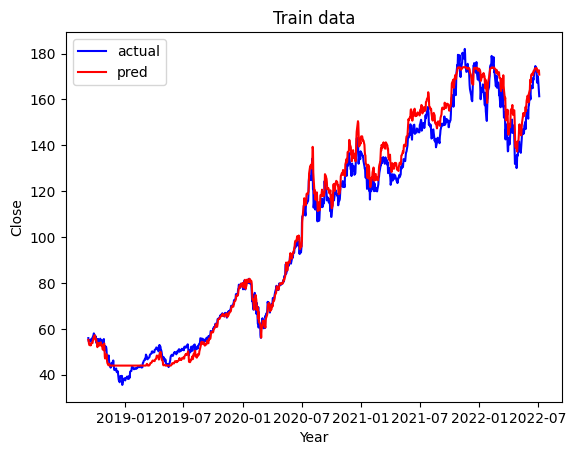

In [51]:
plt.plot(trainActual, color='blue', label='actual')
plt.plot(trainPredictdf, color='red', label='pred')

plt.title('Train data')
plt.xlabel('Year')
plt.ylabel('Close')

plt.legend(loc='best')
plt.show()

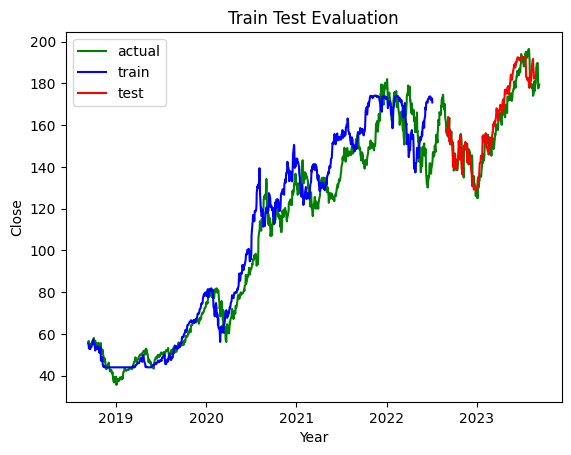

In [52]:
plt.plot(df, color='green', label='actual')
plt.plot(trainPredictdf, color='blue', label='train')
plt.plot(testPredictdf, color='red', label='test')

plt.title('Train Test Evaluation')
plt.xlabel('Year')
plt.ylabel('Close')

plt.legend(loc='best')
plt.show()

## Forecast

In [144]:
input_data = testX[-1]
input_data = np.reshape(input_data, (1, 1, 3))

model.predict(input_data)

1/1 [==============================] - 0s 24ms/step


array([[0.80240595]], dtype=float32)

In [146]:
input_data = testX[-1]
input_data

array([[0.90550189, 0.81044389, 0.7355453 ]])

In [155]:
import numpy as np
from keras.models import load_model


# Define the number of days to predict (n)
n = 7  # Change this to the number of days you want to predict

# Initialize an empty list to store the predictions
predictions = []

# Start predicting the next n days
for i in range(n):
    # Take the last three days' values for prediction
    input_sequence = testX[-3:]
    
    # Make a prediction for the next day
    predicted_value = model.predict(np.expand_dims(input_sequence, axis=0))[0][0]
    
    # Append the predicted value to the list of predictions
    predictions.append(predicted_value)
    
    # Update the input sequence by adding the predicted value
    input_sequence = np.vstack((input_sequence[1:], predicted_value))
    
# Denormalize the predictions if needed (reverse Min-Max scaling)
predictions = predictions * (max_val - min_val) + min_val

# Print the predictions for the next n days
print("Predictions for the next", n, "days:")
print(predictions)


(254, 1, 3)